# Cell density and composition

### Cell density

First, some packages needs to be installed and imported.

In [1]:
# !pip install --upgrade -q -i https://bbpteam.epfl.ch/repository/devpi/simple/ voxcell
# !pip install --upgrade -q bluepysnap

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bluepysnap import Circuit
from bluepysnap.bbp import Cell

from voxcell import VoxelData, RegionMap
from voxcell.nexus.voxelbrain import Atlas

Reading and preparing the data

In [2]:
circuit_path = '/mnt/circuits/O1/20181114/sonata/circuit_config.json'
atlas_path = '/mnt/entities/dev/atlas/O1-243/'

In [4]:
circuit = Circuit(circuit_path, node_population='All')

In [5]:
atlas = Atlas.open(atlas_path)
brain_regions = atlas.load_data('brain_regions')
hierarchy = atlas.load_hierarchy()

In [6]:
regions = ['CA1', 'SLM', 'SR', 'SP', 'SO']
df = pd.DataFrame(index=regions, columns=np.arange(7))

In [7]:
scale = 1000000

for idx in range(7):
    mod = []
    ids1 = hierarchy.collect('acronym', 'mc'+str(idx), 'id')
    gids1 = circuit.nodes.ids({Cell.REGION: {'$regex': 'mc%d;.*' % idx}})
    
    # Neurons in CA1
    mod.append(len(gids1) * scale / brain_regions.volume(ids1))
    
    # SLM neurons in SLM
    ids2 = hierarchy.collect('acronym', 'mc'+str(idx)+';SLM', 'id')
    ids = ids1.intersection(ids2)
    gids2 = circuit.nodes.ids('SLM')
    gids = np.intersect1d(gids1, gids2)
    mod.append(len(gids) * scale / brain_regions.volume(ids))
    
    # SR neurons in SR
    ids2 = hierarchy.collect('acronym', 'mc'+str(idx)+';SR', 'id')
    ids = ids1.intersection(ids2)
    gids2 = circuit.nodes.ids('SR')
    gids = np.intersect1d(gids1, gids2)
    mod.append(len(gids) * scale / brain_regions.volume(ids))
    
    # SP neurons in SP
    ids2 = hierarchy.collect('acronym', 'mc'+str(idx)+';SP', 'id')
    ids = ids1.intersection(ids2)
    gids2 = circuit.nodes.ids('SP')
    gids = np.intersect1d(gids1, gids2)
    mod.append(len(gids) * scale / brain_regions.volume(ids))
    
    # SO neurons in SO
    ids2 = hierarchy.collect('acronym', 'mc'+str(idx)+';SO', 'id')
    ids = ids1.intersection(ids2)
    gids2 = circuit.nodes.ids('SO')
    gids = np.intersect1d(gids1, gids2)
    mod.append(len(gids) * scale / brain_regions.volume(ids))
    
    df[idx] = mod
                            
df.head()

,0,1,2,3,4,5,6
CA1,26.946048,26.968104,26.943873,26.970093,26.968104,26.968104,26.960203
SLM,0.264550,0.262812,0.266312,0.261097,0.262812,0.262812,0.261097
SR,0.118103,0.117327,0.118889,0.116561,0.117327,0.117327,0.116561
SP,291.446208,291.502409,291.389259,291.557876,291.502409,291.502409,291.557876
SO,1.322751,1.391358,1.331558,1.382276,1.391358,1.391358,1.343880


In [8]:
means = df.mean(axis=1)
stds = df.std(axis=1)
df['mean'] = means
df['std'] = stds
df.head()

,0,1,2,3,4,5,6,mean,std
CA1,26.946048,26.968104,26.943873,26.970093,26.968104,26.968104,26.960203,26.960647,0.011186
SLM,0.264550,0.262812,0.266312,0.261097,0.262812,0.262812,0.261097,0.263070,0.001857
SR,0.118103,0.117327,0.118889,0.116561,0.117327,0.117327,0.116561,0.117442,0.000829
SP,291.446208,291.502409,291.389259,291.557876,291.502409,291.502409,291.557876,291.494064,0.060038
SO,1.322751,1.391358,1.331558,1.382276,1.391358,1.391358,1.343880,1.364934,0.030909


### Composition per layer

Here we calculate the composition of ?? per layer.

In [9]:
mtypes = circuit.nodes.property_values(Cell.MTYPE)

In [10]:
columns = range(7)
composition = pd.DataFrame(index=mtypes, columns=columns)
for column in columns:
    for mtype in mtypes:
        composition[column][mtype] = circuit.nodes.count({Cell.MTYPE: mtype, Cell.REGION: {'$regex': 'mc%d;.*' % column}})
composition.head()

,0,1,2,3,4,5,6
SLM_PPA,6,6,6,6,6,6,6
SP_PVBC,65,66,65,66,66,66,66
SP_BS,20,20,20,20,20,20,20
SO_Tri,8,8,8,8,8,8,8
SO_BS,5,6,5,6,6,6,5


In [11]:
means = composition.mean(axis=1)
stds = composition.std(axis=1)
composition['mean'] = means
composition['std'] = stds
composition.head()

,0,1,2,3,4,5,6,mean,std
SLM_PPA,6,6,6,6,6,6,6,6.000000,0.000000
SP_PVBC,65,66,65,66,66,66,66,65.714286,0.487950
SP_BS,20,20,20,20,20,20,20,20.000000,0.000000
SO_Tri,8,8,8,8,8,8,8,8.000000,0.000000
SO_BS,5,6,5,6,6,6,5,5.571429,0.534522


### El ratio

Now we calculate ...

In [12]:
rows = ['EXC', 'INH', 'EXC%']
ratio = pd.DataFrame(index=rows, columns=np.arange(7))
for column in columns:
    for target in ['EXC', 'INH']:
        ratio[column][target] = circuit.nodes.count({Cell.SYNAPSE_CLASS: target, Cell.REGION: {'$regex': 'mc%d;.*' % column}})

In [13]:
ratio.loc['EXC%'] = ratio.loc['EXC']*100/(ratio.loc['EXC']+ratio.loc['INH'])
ratio

,0,1,2,3,4,5,6
EXC,2395,2411,2379,2427,2411,2411,2427
INH,294,298,292,300,298,298,299
EXC%,89.0666,88.9996,89.0678,88.9989,88.9996,88.9996,89.0315


In [14]:
means = ratio.mean(axis=1)
stds = ratio.std(axis=1)
ratio['mean'] = means
ratio['std'] = stds
ratio.head()

,0,1,2,3,4,5,6,mean,std
EXC,2395,2411,2379,2427,2411,2411,2427,2408.714286,17.104719
INH,294,298,292,300,298,298,299,297.000000,2.886751
EXC%,89.0666,88.9996,89.0678,88.9989,88.9996,88.9996,89.0315,89.023382,0.032128


### Cells positions across layers

Here we ...

In [15]:
df = circuit.nodes.positions({Cell.REGION: {'$regex': 'mc2;.*'}})
df.head()

,x,y,z
12,238.209932,520.971013,698.379449
13,210.960984,529.764595,694.686512
14,419.767611,526.048455,617.392636
15,220.391878,522.828070,761.201966
16,252.961402,521.187277,433.179832


In [16]:
x = df['x'].values
y = df['y'].values

/home/povolots/venv/venv36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


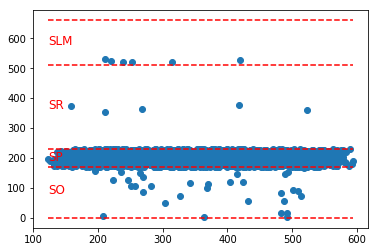

In [17]:
fig, ax = plt.subplots()
ax.scatter(x,y)
layer_heights = (0, 170, 230, 510, 660)
heights = (80, 190, 365, 580)
layers = ('SO', 'SP', 'SR', 'SLM')
ax.hlines(layer_heights, x.min(), x.max(), linestyle='--', colors='r')
for layer, height in zip(layers, heights):
    ax.text(x.min(), height, layer, fontsize=12, color='r')
fig.show()

### Exercise #1
The cell densities calculated above should be compared with literature. Extract data from literature (Aika et al 1994) and compare with the model.

![Aika_etal_1994_Table3](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/Aika_etal_1994_Table3.png)

__Hints__
The table provides more info than you need. For this exercise, focus only on the total number of cells in the entire CA1 and in the different layers. In addition to those 4 datapoints, consider also the PC density in SP.
Furthermore, note that Aika et al considered SLM and SR together (SRLM).

### Exercise #2
Location for CCK and SOM cells. Answer will be a comma separated string from SLM to SO without space. For example, location of PV cells is 'SP'. Store answer in 'ans_2a (for CCK) and 'ans_2b' (for SOM).

### Exercise #3
Calculate density for PV, CCK, and SOM cells. Devide the number to the layer volume where they are present. Store answers in 'ans_3a', 'ans_3b', 'ans_3c'.

In [ ]:
# Work here

In [ ]:
# This is to generate the answers to paste in the submission box below.
# Run this and copy-paste the output into the box below
print json.dumps(dict([("ans_2", ans_2),
                       ("ans_3", ans_3)]))

!pip -q install -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client==0.0.5 
import single_cell_mooc_client as sc_mc
s = sc_mc.Submission(hideToken=True)

In [ ]:
# Show submission widget
s.show_submission(ROLLBACK, TOKEN)